### Q: How do neutral codon probabilities compare to empirical ones?

* How does the answer depend on branch lengths?
* How do multinucleotide codon probabilities compare?

**Terminology**: the _hit class_ of a codon mutation describes the number of differences from the parent codon. E.g. `AAA -> ACT` has hit class 2. I use this terminology to avoid overloaded terms like "number of differences" which gets confusing when we are talking about number of overall differences from parent.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES

from epam import molevol, sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

import sys
sys.path.append("/Users/matsen/re/netam-experiments-1")
from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname, dataset_dict

In [2]:
data_nickname = "shmoof"
pcp_df = pcp_df_of_non_shmoof_nickname(data_nickname)
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)
model = crepe.model
site_count = 500

Loading /Users/matsen/data/shmoof_pcp_2023-11-30_MASKED.csv.gz


We're just going to use shmoof training data, the same data used to train the context NT model.

In [3]:
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df["branch_length"] = pd.read_csv(crepe_path+".train_branch_lengths.csv")["branch_length"]
pcp_df = train_df

In [4]:
def trim_seqs_to_codon_boundary(seqs):
    return [seq[:len(seq) - len(seq) % 3] for seq in seqs]

pcp_df["parent"] = trim_seqs_to_codon_boundary(pcp_df["parent"])
pcp_df["child"] = trim_seqs_to_codon_boundary(pcp_df["child"])

# take the first 1000 row
# pcp_df = pcp_df[:1000].copy()

In [5]:
rates, csps = framework.trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
pcp_df["rates"] = rates
pcp_df["subs_probs"] = csps

In [6]:
def codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, sub_probs):
    """
    Compute the probabilities of mutating to various codons for a parent sequence. 
    
    This uses the same machinery as we use for fitting the DNSM, but we stay on
    the codon level rather than moving to syn/nonsyn changes.
    """
    # This is from `aaprobs_of_parent_scaled_rates_and_sub_probs`:
    mut_probs = 1.0 - torch.exp(-scaled_rates)
    parent_codon_idxs = reshape_for_codons(parent_idxs)
    codon_mut_probs = reshape_for_codons(mut_probs)
    codon_sub_probs = reshape_for_codons(sub_probs)
    
    # This is from `aaprob_of_mut_and_sub`:
    mut_matrices = build_mutation_matrices(parent_codon_idxs, codon_mut_probs, codon_sub_probs)
    codon_probs = codon_probs_of_mutation_matrices(mut_matrices)

    return codon_probs

The following two functions set us up to work with "hit classes", which are the number of differences within a codon as described above. That is, we're calculating the probability of $x$ mutations within a codon given the model.

In [7]:
# This block just sets up `hit_class_tensors`, a dictionary of tensors that we can use to compute the number of differences between codons, as well as `codon_to_idxs` which maps codons to their indices in the tensors.

# Function to calculate the number of differences between two codons
def hit_class(codon1, codon2):
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

# Initialize a dictionary to store hit_class_tensors indexed by codons
hit_class_tensors = {}

# Iterate over all possible codons and calculate the hit_class_tensors
for i, base1 in enumerate(BASES):
    for j, base2 in enumerate(BASES):
        for k, base3 in enumerate(BASES):
            codon = base1 + base2 + base3
            hit_class_tensor = torch.zeros(4, 4, 4, dtype=torch.int)
            for i2, base1_2 in enumerate(BASES):
                for j2, base2_2 in enumerate(BASES):
                    for k2, base3_2 in enumerate(BASES):
                        codon_2 = base1_2 + base2_2 + base3_2
                        hit_class_tensor[i2, j2, k2] = hit_class(codon, codon_2)
            hit_class_tensors[codon] = hit_class_tensor

# make a dict mapping from codon to triple integer index
codon_to_idxs = {base_1+base_2+base_3: (i, j, k) for i, base_1 in enumerate(BASES) for j, base_2 in enumerate(BASES) for k, base_3 in enumerate(BASES)}
codon_to_idxs

ctc_hit_class_tensor = hit_class_tensors["CTC"]
assert ctc_hit_class_tensor[codon_to_idxs["CTC"]] == 0
assert ctc_hit_class_tensor[codon_to_idxs["ATC"]] == 1
assert ctc_hit_class_tensor[codon_to_idxs["ACC"]] == 2
assert ctc_hit_class_tensor[codon_to_idxs["ACT"]] == 3

In [8]:
def hit_class_probs(hit_class_tensor, codon_probs):
    """
    Calculate total probabilities for each number of differences between codons.

    Args:
    - hit_class_tensor (torch.Tensor): A 4x4x4 integer tensor containing the number of differences
                                       between each codon and a reference codon.
    - codon_probs (torch.Tensor): A 4x4x4 tensor containing the probabilities of various codons.

    Returns:
    - total_probs (torch.Tensor): A 1D tensor containing the total probabilities for each number
                                   of differences (0 to 3).
    """
    total_probs = []

    for hit_class in range(4):
        # Create a mask of codons with the desired number of differences
        mask = hit_class_tensor == hit_class

        # Multiply componentwise with the codon_probs tensor and sum
        total_prob = (codon_probs * mask.float()).sum()

        # Append the total probability to the list
        total_probs.append(total_prob.item())

    return torch.tensor(total_probs)

def hit_class_probs_seq(parent_seq, codon_probs, hit_class_tensors):
    """
    Calculate probabilities of hit classes between parent codons and all other codons for all the sites of a sequence.

    Args:
    - parent_seq (str): The parent nucleotide sequence.
    - codon_probs (torch.Tensor): A tensor containing the probabilities of various codons.
    - hit_class_tensors (dict): A dictionary containing hit_class_tensors indexed by codons.

    Returns:
    - probs (torch.Tensor): A tensor containing the probabilities of different
                            counts of hit classes between parent codons and
                            all other codons.
    """
    # Check if the size of the first dimension of codon_probs matches the length of parent_seq divided by 3
    if len(parent_seq) // 3 != codon_probs.size(0):
        raise ValueError("The size of the first dimension of codon_probs should match the length of parent_seq divided by 3.")

    # Initialize a list to store the probabilities of different counts of differences
    probs = []

    # Iterate through codons in parent_seq
    for i in range(0, len(parent_seq), 3):
        # Extract the codon from parent_seq
        codon = parent_seq[i:i+3]

        # if codon contains an N, append a tensor of 4 -1s to probs then continue
        if "N" in codon:
            probs.append(torch.tensor([-100.0] * 4))
            continue

        # Get the corresponding hit_class_tensor from hit_class_tensors
        hit_class_tensor = hit_class_tensors[codon]

        # Get the ith entry of codon_probs
        codon_probs_i = codon_probs[i // 3]

        # Calculate the probabilities of different counts of differences using the hit_class_tensor and codon_probs_i
        total_probs = hit_class_probs(hit_class_tensor, codon_probs_i)

        # Append the probabilities to the list
        probs.append(total_probs)

    # Concatenate all the probabilities into a tensor
    probs = torch.stack(probs)

    return probs


In [9]:
# This block just shows things working for a single parent sequence.

parent, rates, subs_probs, branch_length = pcp_df.loc[0, ["parent", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[9.8838e-01, 1.1576e-02, 3.9784e-05, 3.9472e-08],
        [9.8436e-01, 1.5556e-02, 8.0096e-05, 1.3358e-07],
        [9.8991e-01, 1.0065e-02, 2.6426e-05, 1.5379e-08],
        [9.9122e-01, 8.7560e-03, 2.5097e-05, 2.3505e-08],
        [9.9409e-01, 5.8967e-03, 1.1123e-05, 6.6755e-09],
        [9.8765e-01, 1.2329e-02, 2.4462e-05, 1.1690e-08]])

In [10]:
def hit_classes_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-100)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-100] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
example_hit_classes = hit_classes_of_pcp_df(example_df, 4)
example_hit_classes


tensor([[   0,    0,    1, -100],
        [   0,    0,    1,    2]])

In [11]:
total_hc_probs = torch.zeros(4)
prob_count = 0

all_hc_probs_l = []

# loop through every row of pcp_df
for _, row in pcp_df.iterrows():
    parent = row['parent']
    rates = row['rates']
    subs_probs = row['subs_probs']
    branch_length = row['branch_length']

    parent = parent[:len(parent) - len(parent) % 3]
    rates = rates[:len(rates) - len(rates) % 3]
    subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

    parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
    scaled_rates = branch_length * rates

    codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)

    hc_probs = hit_class_probs_seq(parent, codon_probs, hit_class_tensors)
    all_hc_probs_l.append(hc_probs)

    real_hc_probs = hc_probs[hc_probs.min(axis=1).values > torch.tensor([-99.]), :]
    total_hc_probs += real_hc_probs.sum(dim=0)
    prob_count += real_hc_probs.shape[0]

all_hc_probs = torch.cat(all_hc_probs_l)
all_hc_probs.shape
    
mean_hc_probs = total_hc_probs / prob_count
mean_hc_probs

tensor([9.6143e-01, 3.6899e-02, 1.5889e-03, 6.6378e-05])

Let's prepare for `evaluation.plot_observed_vs_expected`.

In [12]:
observed_hcs = hit_classes_of_pcp_df(pcp_df, site_count//3)

In [13]:
assert len(observed_hcs) == len(pcp_df)

df_rows = []
for seq_idx, (observed_hc_row, hc_probs_row) in enumerate(zip(observed_hcs, all_hc_probs_l)):
    for site_idx, (observed_hc, diff_prob_vect) in enumerate(zip(observed_hc_row, hc_probs_row[:len(observed_hc_row)])):
        if observed_hc >= 0: # filtering out N-containing codons
            v = tuple(diff_prob_vect.detach().numpy())
            df_rows.append((seq_idx, site_idx, observed_hc.item()) + v)
       
pre_obs_vs_exp_df = pd.DataFrame(df_rows, columns=["sequence", "site", "hit_class", "0_hc_prob", "1_hc_prob", "2_hc_prob", "3_hc_prob"])

In [14]:
pre_obs_vs_exp_df

,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob
0,0,22,0,0.974763,0.025093,0.000144,2.233629e-07
1,0,23,0,0.989015,0.010949,0.000036,3.661007e-08
2,0,24,0,0.988221,0.011735,0.000044,5.314208e-08
3,0,25,0,0.970510,0.029207,0.000283,8.662984e-07
4,0,26,0,0.970194,0.029513,0.000292,9.378916e-07
...,...,...,...,...,...,...,...
4347072,46390,113,0,0.980833,0.019044,0.000122,2.589745e-07
4347073,46390,114,0,0.972725,0.027045,0.000230,5.472509e-07
4347074,46390,115,0,0.978668,0.021185,0.000147,3.301825e-07
4347075,46390,116,0,0.985519,0.014415,0.000066,9.227706e-08


In [15]:
# compute quartiles of pcp_df["branch_length"]
pcp_quantiles = pcp_df["branch_length"].quantile([0.25, 0.5, 0.75])
# add a quantile column to pcp_df
pcp_df["branch_length_quantile"] = pd.qcut(pcp_df["branch_length"], q=4, labels=False)
pcp_quantiles

0.25    0.003484
0.50    0.006826
0.75    0.016779
Name: branch_length, dtype: float64

In [16]:
# turn pcp_df["branch_length_quantile"] into a dict mapping from idx to quantile
branch_length_quantile_dict = pcp_df["branch_length_quantile"].to_dict()
pre_obs_vs_exp_df["branch_length_quantile"] = pre_obs_vs_exp_df["sequence"].map(branch_length_quantile_dict)
pre_obs_vs_exp_df

,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.974763,0.025093,0.000144,2.233629e-07,1
1,0,23,0,0.989015,0.010949,0.000036,3.661007e-08,1
2,0,24,0,0.988221,0.011735,0.000044,5.314208e-08,1
3,0,25,0,0.970510,0.029207,0.000283,8.662984e-07,1
4,0,26,0,0.970194,0.029513,0.000292,9.378916e-07,1
...,...,...,...,...,...,...,...,...
4347072,46390,113,0,0.980833,0.019044,0.000122,2.589745e-07,2
4347073,46390,114,0,0.972725,0.027045,0.000230,5.472509e-07,2
4347074,46390,115,0,0.978668,0.021185,0.000147,3.301825e-07,2
4347075,46390,116,0,0.985519,0.014415,0.000066,9.227706e-08,2


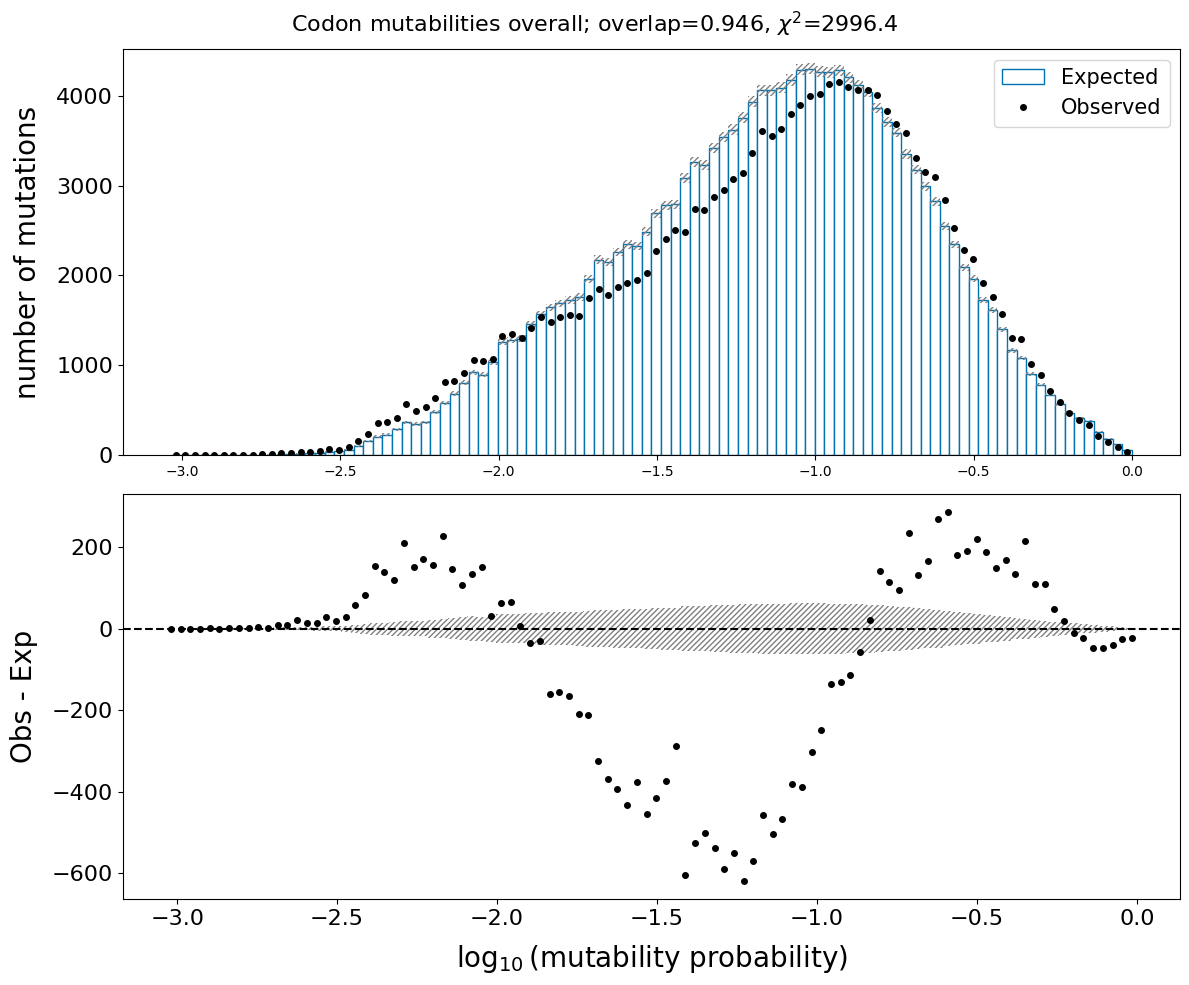

In [20]:
def simple_obs_vs_exp(pre_obs_vs_exp_df, description):
    """
    No partitioning by mutation class.
    """
    plot_df = pd.DataFrame({
        "mutation": pre_obs_vs_exp_df["hit_class"] > 0,
        "prob": 1 - pre_obs_vs_exp_df["0_hc_prob"],
    })
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    min_mutated_logprob = np.log10(plot_df[plot_df["mutation"]]["prob"]).min()
    binning=np.linspace(1.05*min_mutated_logprob, 0, 101)
    result_dict = evaluation.plot_observed_vs_expected(plot_df, axs, logprobs=True, binning=binning)
    fig.suptitle(f"{description}; overlap={result_dict['overlap']:.3g}, $\chi^2$={result_dict['chisq']:.1f}", fontsize=16)
    fig.tight_layout()
    return fig, result_dict

fig, result_dict = simple_obs_vs_exp(pre_obs_vs_exp_df, "Codon mutabilities overall")

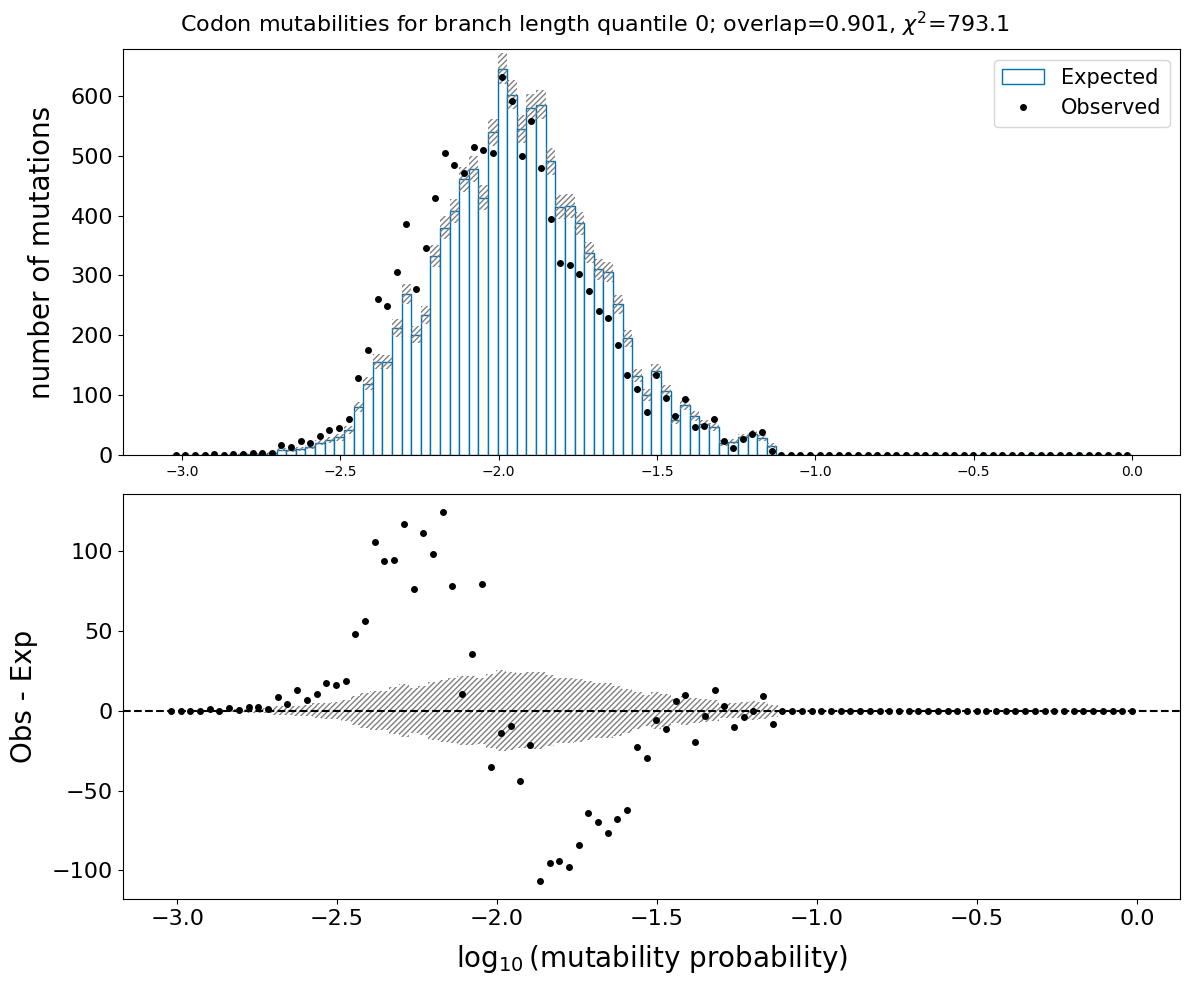

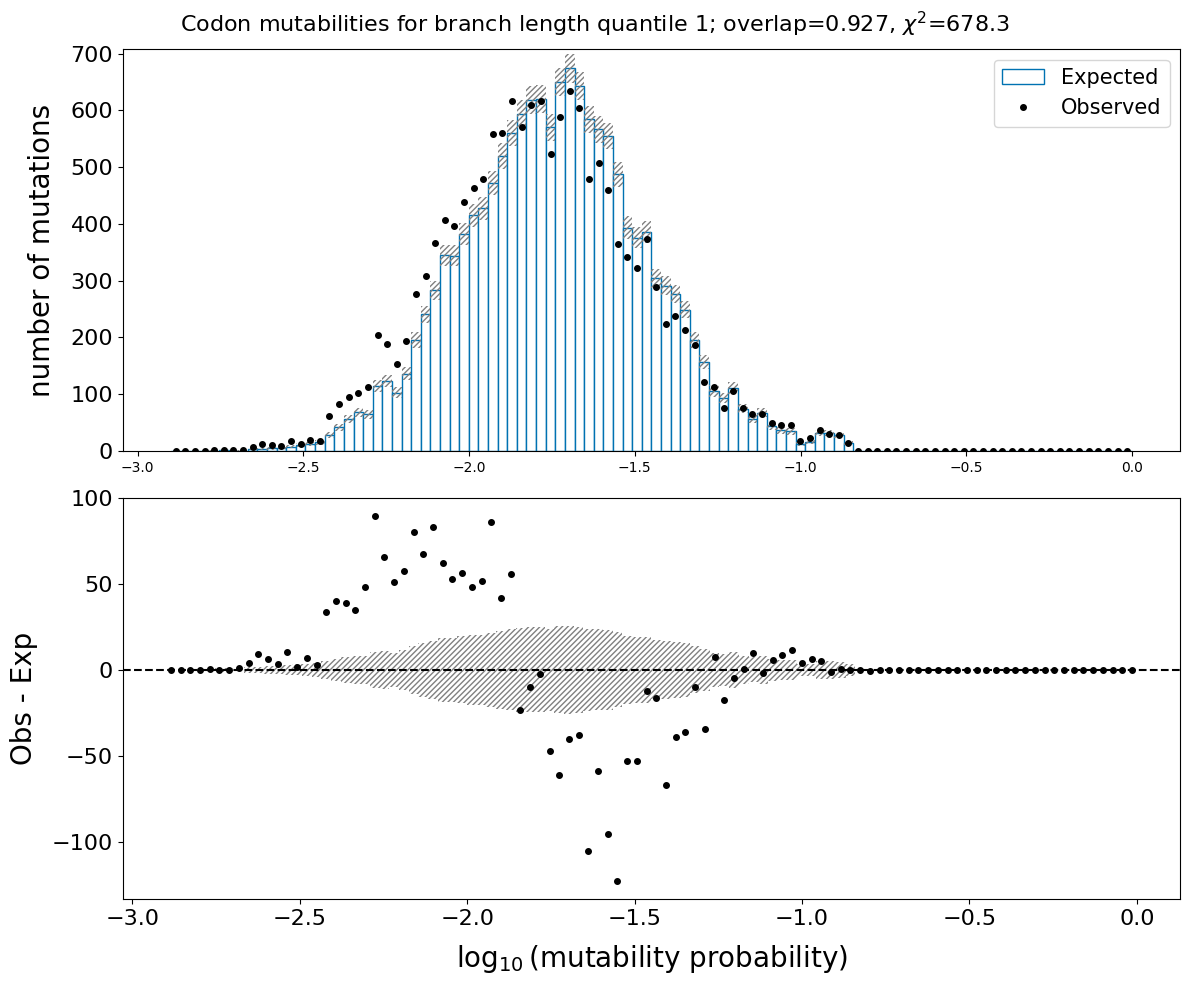

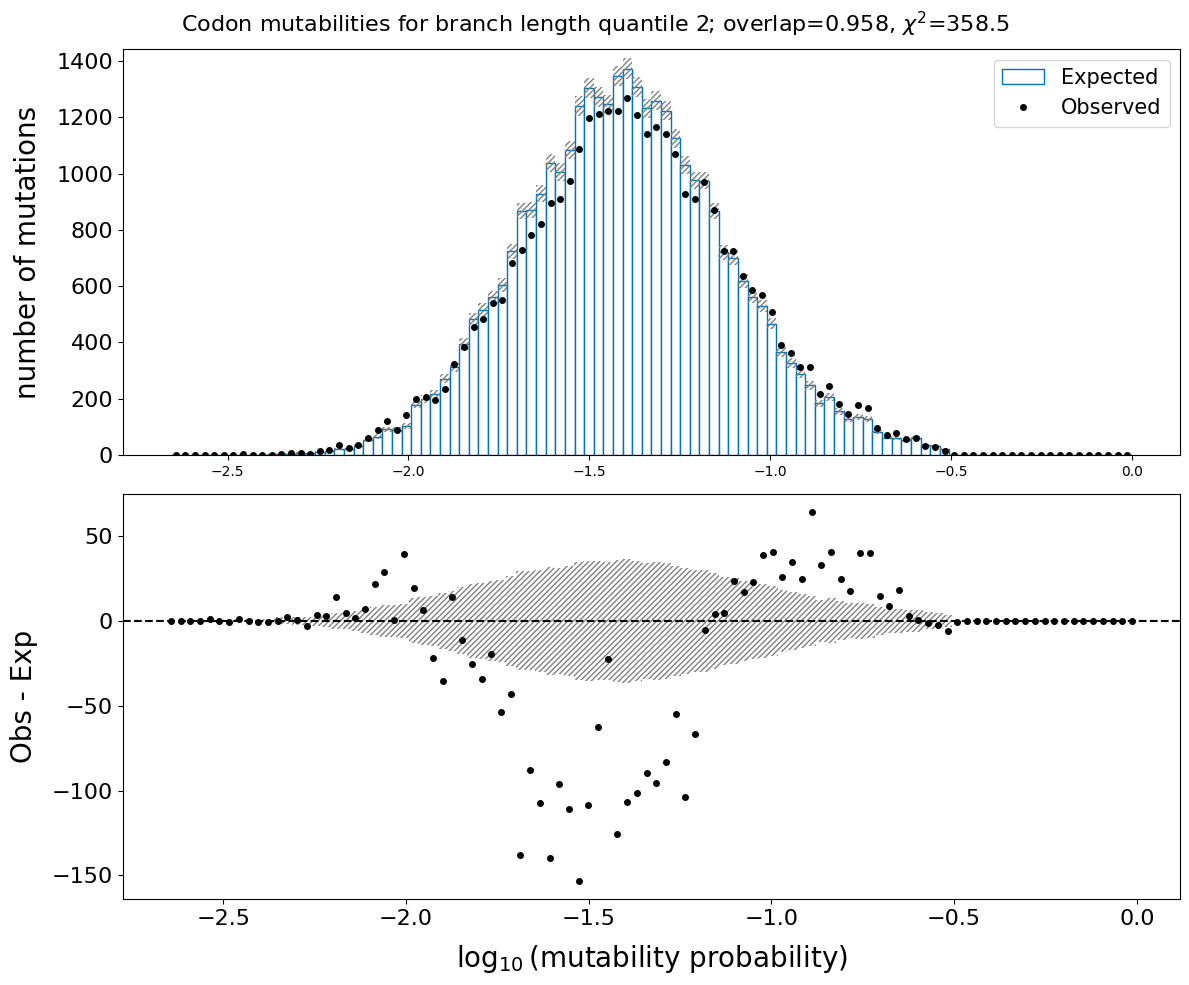

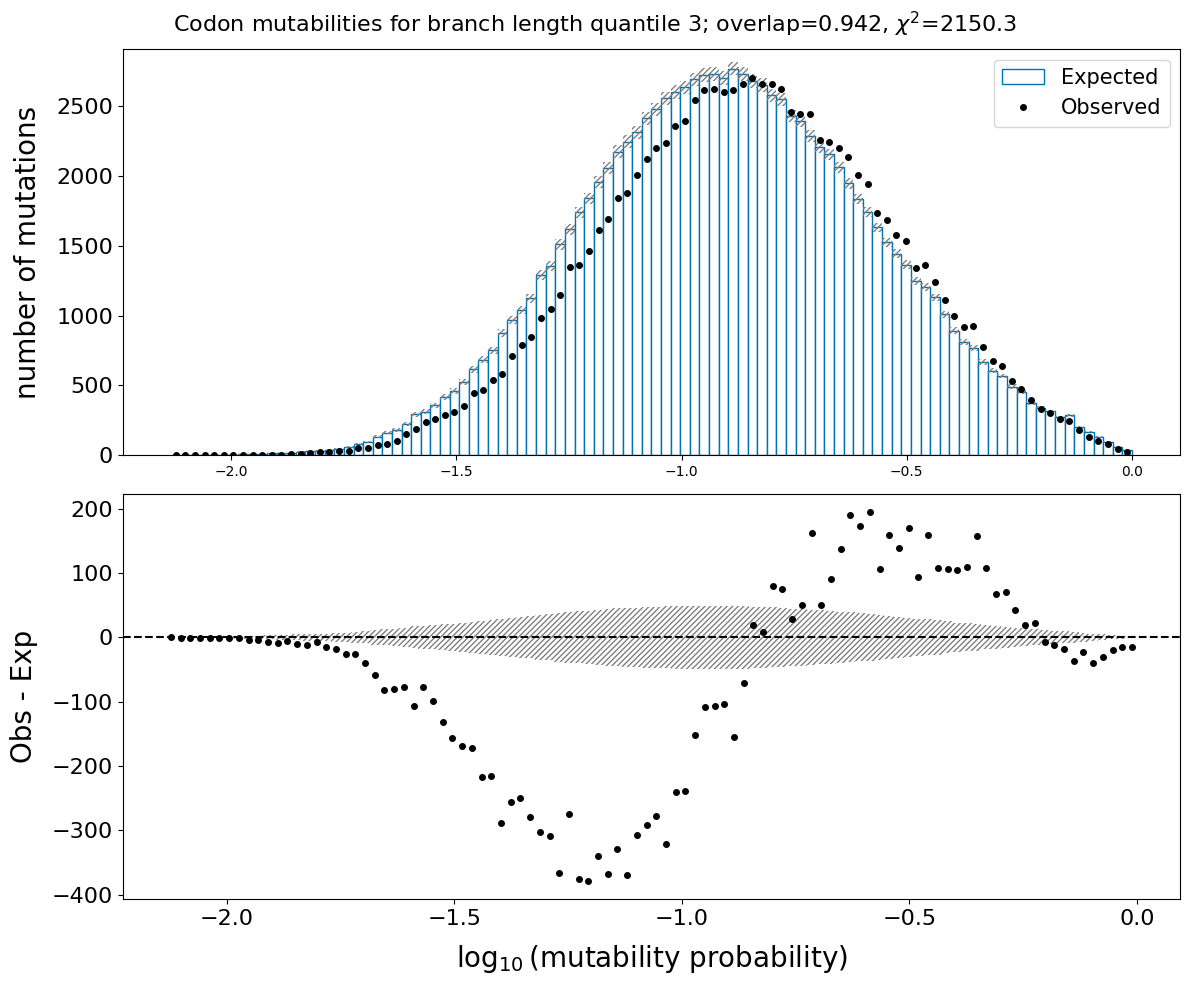

In [21]:
# loop over a groupby of pcp_df["branch_length_quantile"]
figs = []
results = []
for quantile, group in pre_obs_vs_exp_df.groupby("branch_length_quantile"):
    fig, result = simple_obs_vs_exp(group, f"Codon mutabilities for branch length quantile {quantile}")
    figs.append(fig)
    results.append(result)

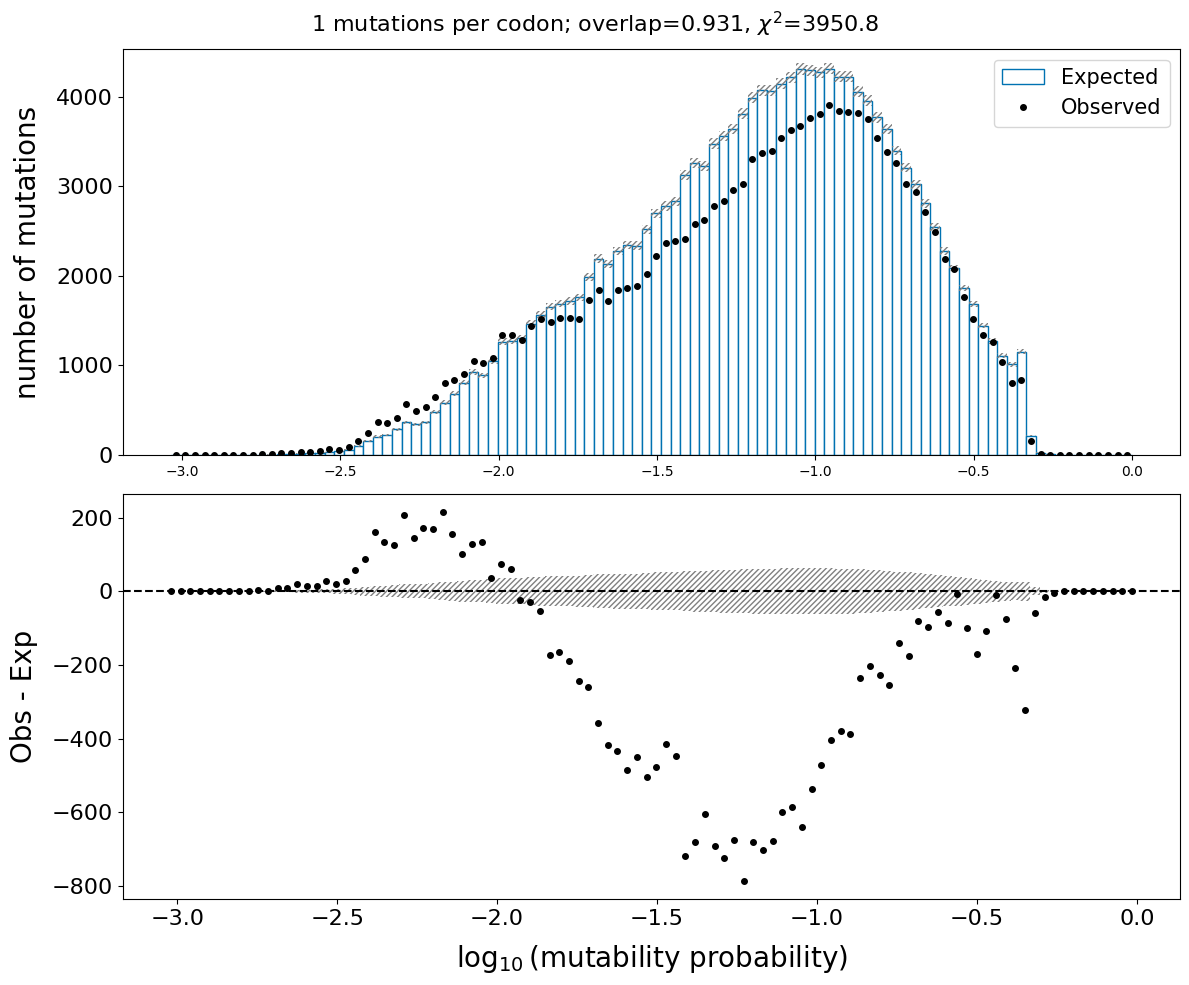

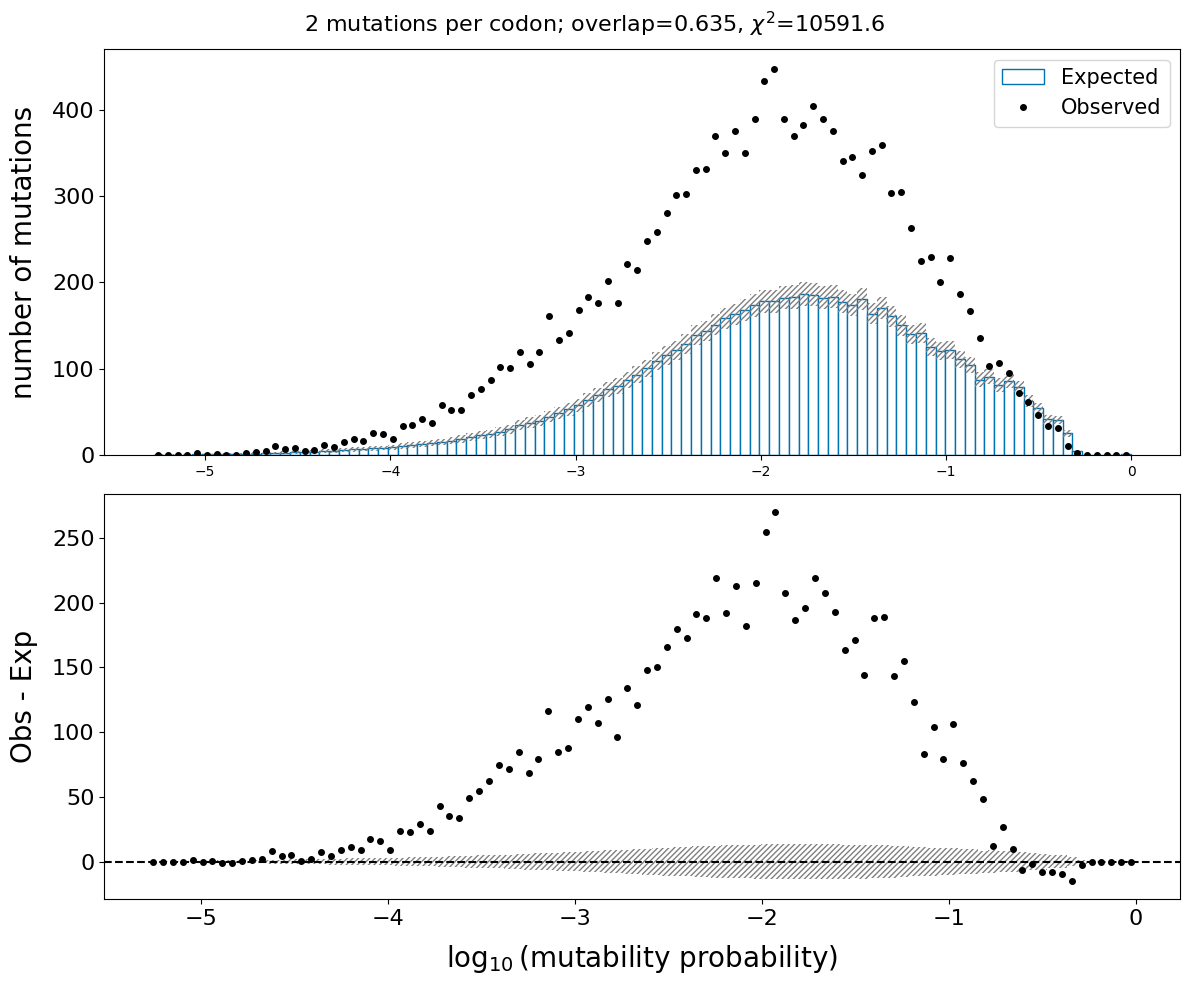

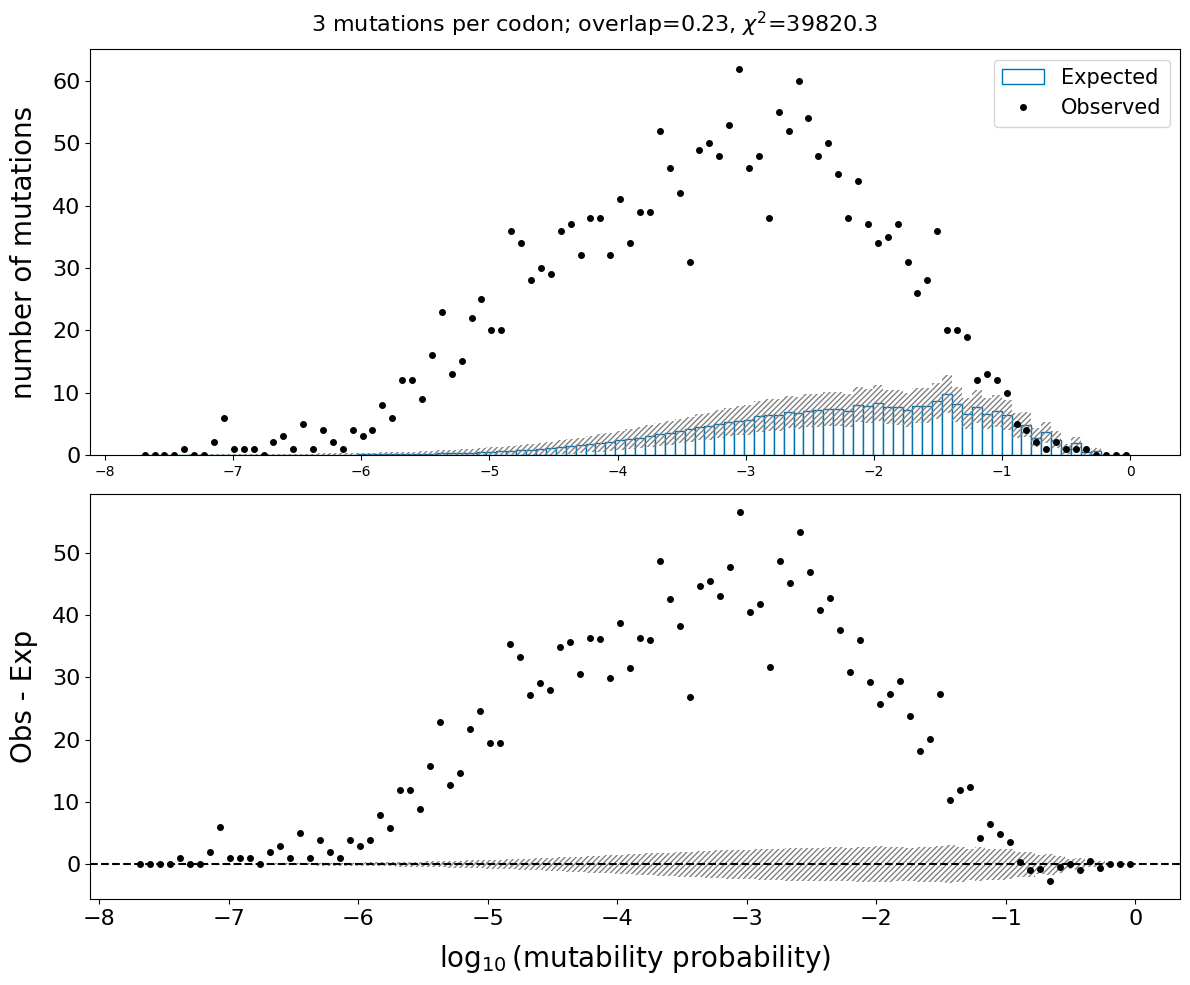

In [22]:
for hit_class in range(1, 4):
    plot_df = pd.DataFrame({
        "mutation": pre_obs_vs_exp_df["hit_class"] == hit_class,
        "prob": pre_obs_vs_exp_df[f"{hit_class}_hc_prob"],
    })
    min_mutated_logprob = np.log10(plot_df[plot_df["mutation"]]["prob"]).min()
    binning=np.linspace(1.05*min_mutated_logprob, 0, 101)
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    result_dict = evaluation.plot_observed_vs_expected(plot_df, axs, logprobs=True, binning=binning)
    # do np.log10(plot_df["prob"]).hist() on axs[2]
    # np.log10(plot_df["prob"]).hist(ax=axs[2], bins=50)
    fig.suptitle(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, $\chi^2$={result_dict['chisq']:.1f}", fontsize=16)
    fig.tight_layout()
    fig.savefig(f"_ignore/obs_vs_exp_{hit_class}_mutations_per_codon.png")